(1024, 683)


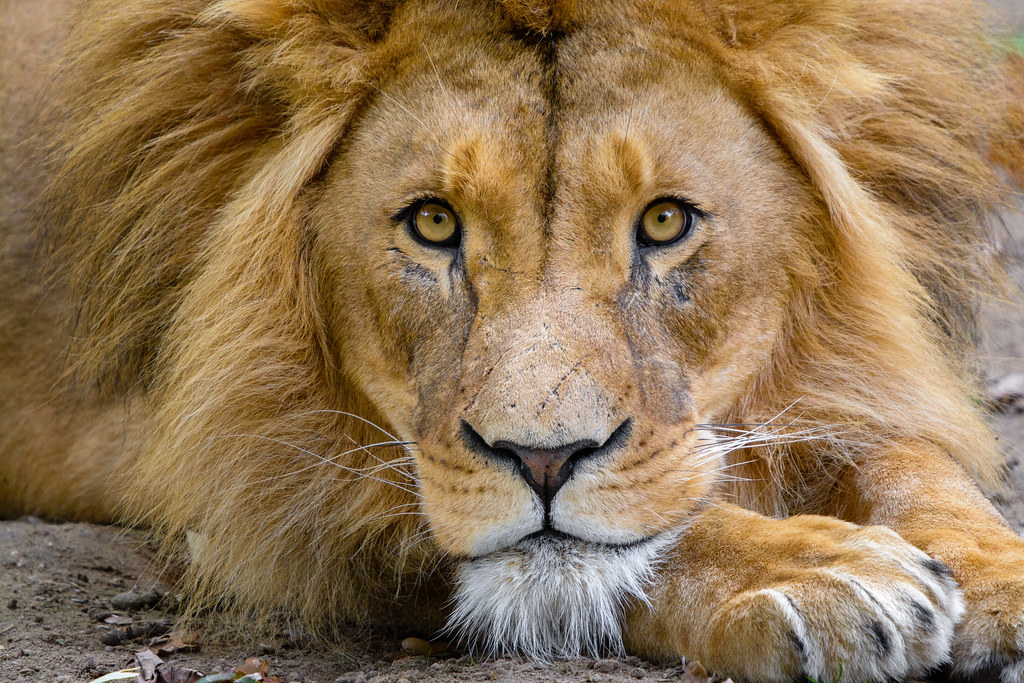

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from sklearn.cluster import KMeans

# Load an image to transform
image_path = './images/lion/lion.jpg'
img_orig = Image.open(image_path)
print(img_orig.size)
img_orig

(900, 600)


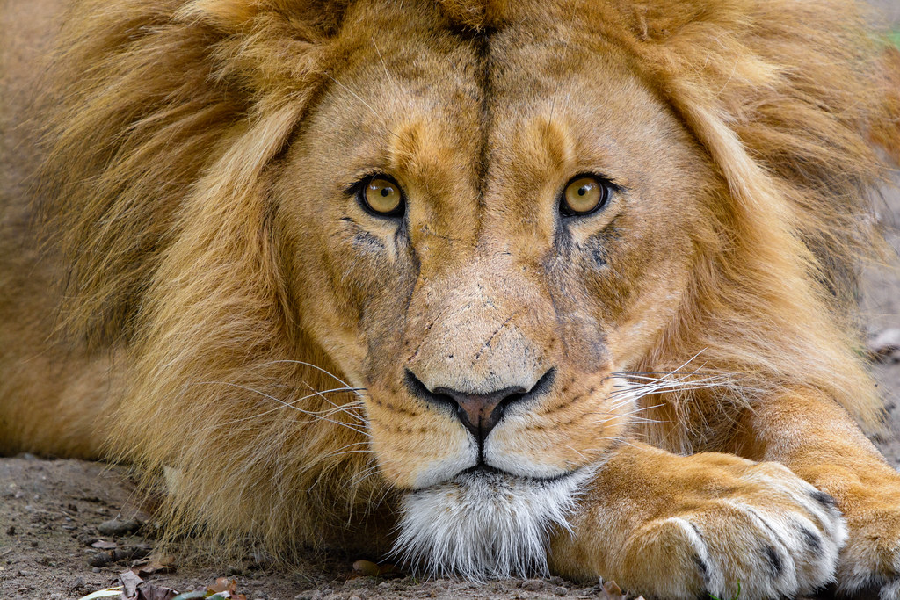

In [2]:
# The original image can be of any arbitrary size, but we need a specific fixed size for 
# This block resizes the original image to the desired size

# Width x Height
# Specifiy height as None to keep aspect ratio
target_size = [600, None]

if target_size[1] is None:
    target_size[1] = round((target_size[0] * img_orig.size[0]) / img_orig.size[1])

img_resized = img_orig.resize(target_size[::-1])
print(img_resized.size)
img_resized

In [3]:
# Lets convert the PIL Image to a Numpy Ndarray for further processing
img_resized_np = np.array(img_resized)
img_resized_np.shape

(600, 900, 3)

(75, 113, 3)


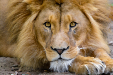

In [4]:
# A Rhinestone will typically be more than a pixel wide
# Here we set the size of the Rhinestone and club pixels to obtain one color per stone
# Note: the last block might be smaller than stone_size, if stone_size is not a factor of target_size

stone_size = [8,8]
img_stoned = np.zeros((
    int(np.ceil(img_resized_np.shape[0]/stone_size[0])),
    int(np.ceil(img_resized_np.shape[1]/stone_size[1])),
    img_resized_np.shape[2]
))

for i in range(img_stoned.shape[0]):
    for j in range(img_stoned.shape[1]):
        range_x = i*stone_size[0], min((i+1)*stone_size[0], img_resized_np.shape[0])
        range_y = j*stone_size[1], min((j+1)*stone_size[1], img_resized_np.shape[1])
        block = img_resized_np[range_x[0]:range_x[1], range_y[0]:range_y[1], :]
        block = block.reshape(-1, block.shape[2])
        img_stoned[i,j,:] = np.median(block, axis=0, keepdims=False)
        
# Lets view the transfored image
print(img_stoned.shape)
Image.fromarray(img_stoned.astype(np.uint8))

In [5]:
# K-Means Clustering - Find K most representative colors
K = 20
kmeans = KMeans(n_clusters=K).fit(img_stoned.reshape(-1, 3))

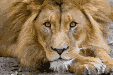

In [6]:
# Replace all the pixels in the image with the corresponding cluster centers
img_kmeans = np.zeros(img_stoned.shape).reshape(-1, 3)
for i in range(kmeans.labels_.size):
    img_kmeans[i, :] = kmeans.cluster_centers_[kmeans.labels_[i]]
img_kmeans = img_kmeans.reshape(img_stoned.shape)

# Lets view the transfored image
Image.fromarray(img_kmeans.astype(np.uint8))

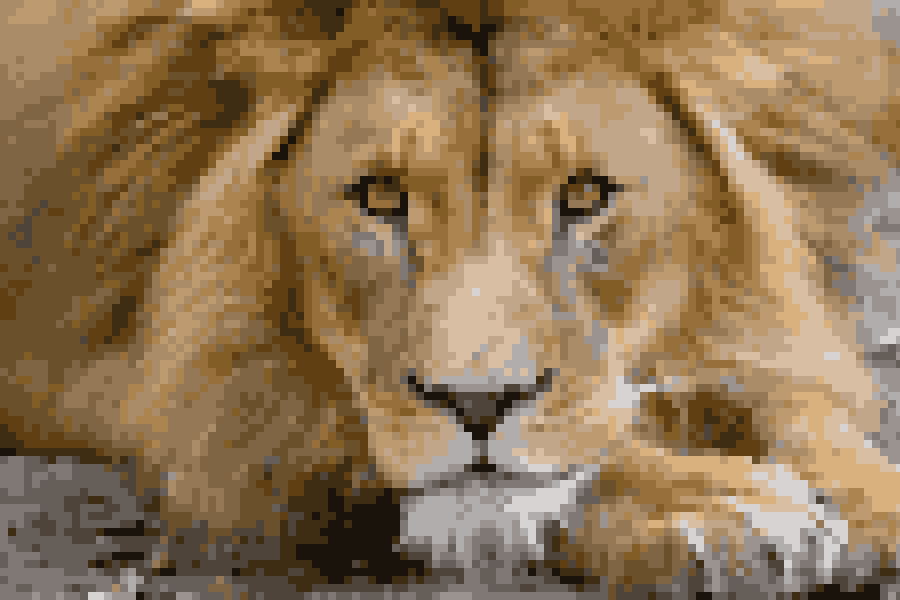

In [7]:
# The image needs to be expanded to the actual size

img_final = np.zeros_like(img_resized_np)

for i in range(img_kmeans.shape[0]):
    for j in range(img_kmeans.shape[1]):
        range_x = i*stone_size[0], min((i+1)*stone_size[0], img_resized_np.shape[0])
        range_y = j*stone_size[1], min((j+1)*stone_size[1], img_resized_np.shape[1])
        block = img_final[range_x[0]:range_x[1], range_y[0]:range_y[1], :]
        block[:,:,:] = img_kmeans[i,j,:]
        
# Lets view the final image
Image.fromarray(img_final.astype(np.uint8))

In [8]:
# A utility method to get a contrasting color

def get_contrasting_color(r,g,b):
    return tuple(map(lambda x: 0 if x >= 128 else 255, (r, g, b)))
get_contrasting_color(23, 129, 213)

(255, 0, 0)

In [9]:
# Lets define a function for rendering a label over an image.
# This wil be useful for labeling the final image and color charts

def draw_text(draw, text, box_size, box_color):
    font = ImageFont.truetype('NotoSansMono-Light.ttf', int(min(box_size)/1.5))
    text_size = draw.textsize(text, font)
    text_center = ((box_size[0]-text_size[0])/2, (box_size[1]-text_size[1])/2)
    text_color = get_contrasting_color(*box_color)
    draw.text(text_center, text, fill=text_color, font=font)
    

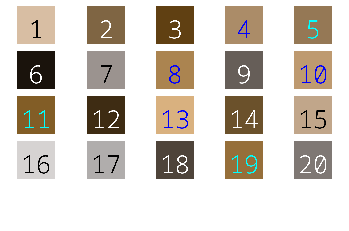

In [10]:
# Here we are creating k unique labels for each of the representative colors

rep_colors = []
rect_size = (200,200)

for i in range(K):
    color_rect = Image.new('RGB', rect_size)
    draw = ImageDraw.Draw(color_rect)

    rect_color = tuple(map(int, kmeans.cluster_centers_[i].tolist()))
    draw.rectangle(((0, 0), rect_size), fill=rect_color)
    draw_text(draw, str(i+1), rect_size, rect_color)
    
    rep_colors.append(np.array(color_rect))

# Lets view the unique color labels
plots_per_row = max(2, int(np.ceil(np.sqrt(K))))
fig, axes = plt.subplots(plots_per_row, plots_per_row)
for i in range(plots_per_row**2):
    ax = axes[i // plots_per_row, i % plots_per_row]
    ax.axis('off')
    if i < K:
        ax.imshow(rep_colors[i])
    

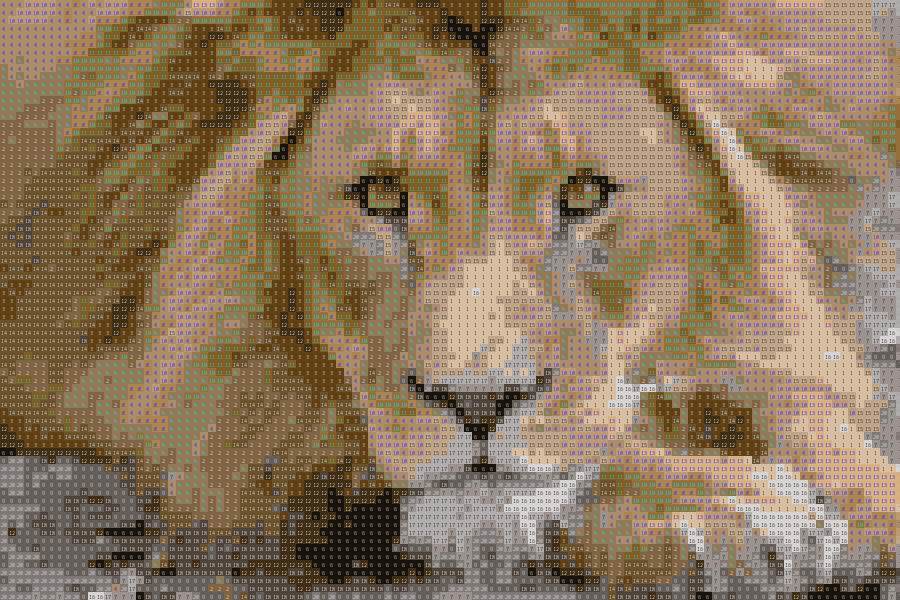

In [12]:
# Finally, we'll overlay the labels on the image to help us identify the color

img_labeled = np.zeros_like(img_final)
pix_labels = kmeans.labels_.reshape(img_kmeans.shape[0], img_kmeans.shape[1])

for i in range(pix_labels.shape[0]):
    for j in range(pix_labels.shape[1]):
        range_x = i*stone_size[0], min((i+1)*stone_size[0], img_labeled.shape[0])
        range_y = j*stone_size[1], min((j+1)*stone_size[1], img_labeled.shape[1])
        block_labelled = img_labeled[range_x[0]:range_x[1], range_y[0]:range_y[1], :]
        block_final = img_final[range_x[0]:range_x[1], range_y[0]:range_y[1], :]
        
        label = pix_labels[i,j]
        img_block = Image.fromarray(block_final.astype(np.uint8))
        draw = ImageDraw.Draw(img_block)
        block_color = tuple(map(int, kmeans.cluster_centers_[label].tolist()))
        draw_text(draw, str(label+1), block_final.shape[:-1], block_color)
        block_labelled[:,:,:] = np.array(img_block)
        
# Lets view the final image
Image.fromarray(img_labeled.astype(np.uint8))